# Chapter 1 of PhD thesis

This notebook contains code used to generate images from Chapter 1 of my PhD thesis, which presents a general overview of Arctic sea, taking insights from both observational and model data.

Where data downloads are required, information on data access is given as a heading above each cell

In [20]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pickle
from scipy import stats
import os
from netCDF4 import Dataset
from scipy.interpolate import griddata

%matplotlib inline

#setup LaTeX style font 
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsfonts}",r"\usepackage{amsmath}"]
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 20

def cmap_discretize(cmap, N): 
    """Return a discrete colormap from the continuous colormap cmap.    
    cmap: colormap instance, eg. cm.jet.  
    N: number of colors.    
    Example
    x = resize(arange(100), (5,100))
    djet = cmap_discretize(cm.jet, 5)
    imshow(x, cmap=djet)
    """
    if type(cmap) == str:
        cmap = mpl.cm.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(1./N*0.5, 1-(1./N*0.5), N), (0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) for i in range(N+1) ]
    return mpl.colors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)

def draw_meridians(m, ax, hemisphere, width_percent=0.03, degree=30, meridians=False, fontsize=20):
    """
    Add circular meridians around Basemap image when using round=True call
    """
    from matplotlib.patches import Wedge
    centre_x = (ax.get_xlim()[0] + ax.get_xlim()[1]) / 2
    centre_y = (ax.get_ylim()[0] + ax.get_ylim()[1]) / 2
    width = abs(centre_x) * width_percent

    inner_radius = (abs(centre_x) - width/2) + 4e4
    outer_radius = inner_radius + width

    angle_breaks = list(range(0, 361, degree))

    for i, (from_angle, to_angle) in enumerate(list(zip(angle_breaks[:-1], angle_breaks[1:]))):
        color='white' if i%2 == 0 else 'black'
        wedge = Wedge((centre_x, centre_y), outer_radius, from_angle, to_angle, width=outer_radius - inner_radius, 
                      facecolor=color,
                      edgecolor='black',
                      clip_on=False,
                      ls='solid',
                      lw=1)
        ax.add_patch(wedge)


# Figure 1.1: Arctic seas and the seasonal sea ice cover

Daily and monthly NASA team ssea ice concentration data can be found at the following location:

https://nsidc.org/data/NSIDC-0051/versions/1

Grid information for NSIDC data can be found at:

https://nsidc.org/data/polar-stereo/tools_geo_pixel.html#psn25lats_v3.dat_pss25lats_v3.dat


/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: Mean of empty slice
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in greater_equal
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in greater_equal
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value 

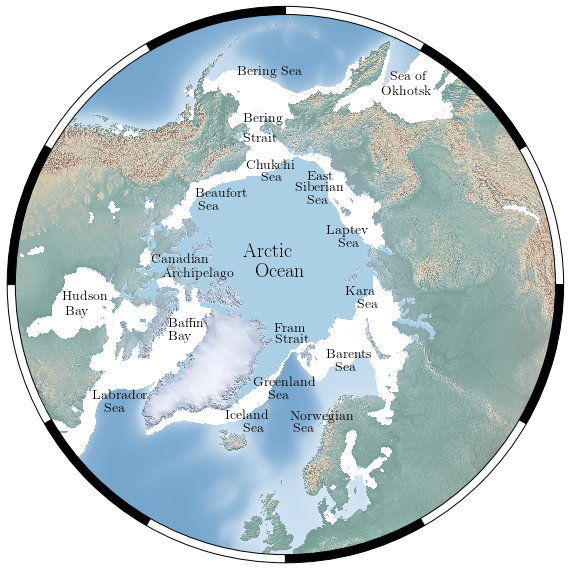

In [6]:
def readSIC():
    """
    Read NASA team sea ice concentration data (monthly up until 2020, daily for 2021)
    Store each monthly averaged field in a dictionary file
    """
    import glob
    import struct
    dimX = 448
    dimY = 304
    months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
    SIC = {}
    SIC['lat'] = (np.fromfile("data/GRIDS/psn25lats_v3.dat",dtype='<i4').reshape(dimX,dimY))/100000
    SIC['lon'] = (np.fromfile("data/GRIDS/psn25lons_v3.dat",dtype='<i4').reshape(dimX,dimY))/100000
    SIC['psa'] = (np.fromfile("data/GRIDS/psn25area_v3.dat",dtype='<i4').reshape(dimX,dimY))/1000
    for month in range(12):
        monthID = str("%02d"%(month+1))
        days = sorted(glob.glob("data/SIC/daily/2021/nt_2021"+str(monthID)+"*.bin"))
        daily = np.zeros((dimX,dimY,len(days)))*np.nan
        monthly = np.zeros((dimX,dimY,2020-1979+1))*np.nan
        k = -1
        for d in days:
            k = k + 1
            icefile = open(d, "rb")
            contents = icefile.read()
            icefile.close()
            s="%dB" % (int(dimX*dimY),)
            z=struct.unpack_from(s, contents, offset = 300)
            daily[:,:,k] = np.array(z).reshape((dimX,dimY))
        daily = daily/250
        daily[daily>1]=np.nan       
        month_fm_daily = np.nanmean(daily, axis=2)
        k = 0
        for y in range(1979,2020+1):
            icefile = open(glob.glob("data/SIC/monthly/nt_"+str(y)+str(monthID)+"*.bin")[0], "rb")
            contents = icefile.read()
            icefile.close()
            s="%dB" % (int(dimX*dimY),)
            z=struct.unpack_from(s, contents, offset = 300)
            monthly[:,:,k] = np.array(z).reshape((dimX,dimY))
            k = k + 1
        monthly = monthly/250
        monthly[monthly>1]=np.nan
        data = np.concatenate((monthly,month_fm_daily[:,:,np.newaxis]),2)
        SIC[months[month]+'_data'] = data
    return SIC

SIC = readSIC()

m = Basemap(projection='npstere',boundinglat=50,lon_0=0,resolution='l',round=True)
bering_x,bering_y = m(178.1395,56.9073)
soo_x,soo_y = m(149.3658,52.8736)
beau_x,beau_y = m(-145.5685,72.8431)
chuk_x,chuk_y = m(-168,72)
ess_x,ess_y = m(165.5685,69.8431)
lap_x,lap_y = m(140.5685,78.8431)
kar_x,kar_y = m(90,80)
bar_x,bar_y = m(35,80)
fram_x,fram_y = m(0,85)
green_x,green_y = m(0,78)
nor_x,nor_y = m(15,67)
hud_x,hud_y = m(-85.2539,57)
caa_x,caa_y = m(-100,71)
baff_x,baff_y = m(-70,71)
lab_x,lab_y = m(-55,60)
polex,poley = m(0,90)
ACx,ACy = m(0,66.3)
AC = plt.Circle((polex,poley),abs(ACy-poley),color='black',fill=False,linewidth=2,linestyle='--')
mar_extent = np.nanmean(SIC['mar_data'],2)
sep_extent = np.nanmean(SIC['sep_data'],2)
sep_extent[SIC['lat']<65] = np.nan
mar_extent[mar_extent>=.15] = 1
sep_extent[sep_extent>=.15] = 2
sep_extent[SIC['lat']>88] = 2
mar_extent[SIC['lat']>88] = 1
mar_extent[mar_extent<.15] = np.nan
sep_extent[sep_extent<.15] = np.nan
fig,ax = plt.subplots(1,figsize=(10,10))
m = Basemap(projection='npstere',boundinglat=50,lon_0=0,resolution='l',round=True,ax=ax)
x,y = m(SIC['lon'],SIC['lat'])
ax.text(bering_x-.95e6,bering_y-.2e6,'Bering Sea',color='black',fontsize=14)
ax.text(bering_x-.85e6,bering_y-1e6,'Bering',color='black',fontsize=14)
ax.text(bering_x-.85e6,bering_y-1.35e6,'Strait',color='black',fontsize=14)
ax.text(soo_x-.4e6,soo_y-.2e6,'Sea of',color='black',fontsize=14)
ax.text(soo_x-.55e6,soo_y-.45e6,'Okhotsk',color='black',fontsize=14)
ax.text(beau_x-.45e6,beau_y-.1e6,'Beaufort',color='black',fontsize=14)
ax.text(beau_x-.4e6,beau_y-.3e6,'Sea',color='black',fontsize=14)
ax.text(chuk_x-.25e6,chuk_y,'Chukchi',color='black',fontsize=14)
ax.text(chuk_x,chuk_y-.2e6,'Sea',color='black',fontsize=14)
ax.text(ess_x-.2e6,ess_y-.4e6,'East',color='black',fontsize=14)
ax.text(ess_x-.4e6,ess_y-.6e6,'Siberian',color='black',fontsize=14)
ax.text(ess_x-.2e6,ess_y-.8e6,'Sea',color='black',fontsize=14)
ax.text(lap_x-.1e6,lap_y-.1e6,'Laptev',color='black',fontsize=14)
ax.text(lap_x+.1e6,lap_y-.3e6,'Sea',color='black',fontsize=14)
ax.text(kar_x-.1e6,kar_y-.18e6,'Kara',color='black',fontsize=14)
ax.text(kar_x+.1e6,kar_y-.38e6,'Sea',color='black',fontsize=14)
ax.text(bar_x+.05e6,bar_y-.35e6,'Barents',color='black',fontsize=14)
ax.text(bar_x+.2e6,bar_y-.55e6,'Sea',color='black',fontsize=14)
ax.text(caa_x-.2e6,caa_y,'Canadian',color='black',fontsize=14)
ax.text(caa_x-.15,caa_y-.25e6,'Archipelago',color='black',fontsize=14)
ax.text(baff_x,baff_y,'Baffin',color='black',fontsize=14)
ax.text(baff_x-.15,baff_y-.2e6,'Bay',color='black',fontsize=14)
ax.text(lab_x-.5e6,lab_y,'Labrador',color='black',fontsize=14)
ax.text(lab_x-.3e6,lab_y-.2e6,'Sea',color='black',fontsize=14)
ax.text(fram_x-.2e6,fram_y-.25e6,'Fram',color='black',fontsize=14)
ax.text(fram_x-.18e6,fram_y-.45e6,'Strait',color='black',fontsize=14)
ax.text(green_x-.55e6,green_y-.4e6,'Greenland',color='black',fontsize=14)
ax.text(green_x-.3e6,green_y-.6e6,'Sea',color='black',fontsize=14)
ax.text(nor_x-.6e6,nor_y+.2e6,'Norwegian',color='black',fontsize=14)
ax.text(nor_x-.55e6,nor_y,'Sea',color='black',fontsize=14)
ax.text(nor_x-1.7e6,nor_y+.2e6,'Iceland',color='black',fontsize=14)
ax.text(nor_x-1.4e6,nor_y,'Sea',color='black',fontsize=14)
ax.text(hud_x-.05e6,hud_y+.5e5,'Hudson',color='black',fontsize=14)
ax.text(hud_x,hud_y-2e5,'Bay',color='black',fontsize=14)
ax.text(chuk_x-.3e6,chuk_y-1.5e6,'Arctic',color='black',fontsize=20)
ax.text(chuk_x-.1e6,chuk_y-1.85e6,'Ocean',color='black',fontsize=20)
m.pcolormesh(x,y,mar_extent,vmin=0,vmax=1,cmap='Greys_r',rasterized=True)
m.pcolormesh(x,y,sep_extent,vmin=1.5,vmax=3,cmap='Blues',rasterized=True)

m.shadedrelief()
draw_meridians(m,ax,hemisphere='north')
plt.show()

# Figure 1.2: Large-scale surface ocean currents

Data were sourced from the Centre for Polar Observation and Modelling (CPOM) at University College London.
Please contact Dr. Harry Heorton for data access (h.heorton@ucl.ac.uk)

/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: The following kwargs were not used by contour: 'rasterized'


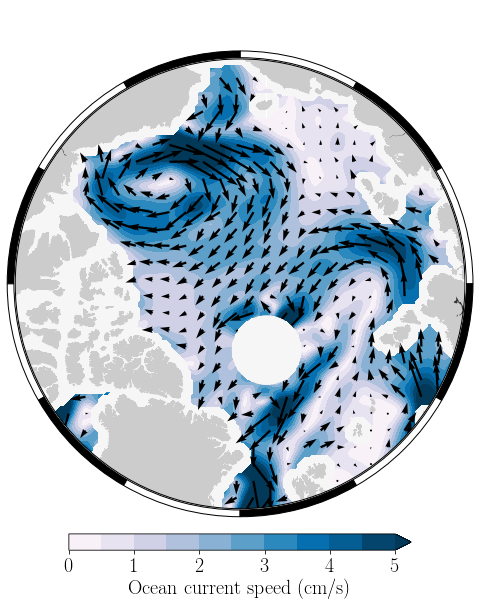

In [9]:
fig,ax = plt.subplots(1,figsize=(10,10))

m = Basemap(llcrnrlon=-50, llcrnrlat=65, urcrnrlon=150, urcrnrlat=60,
                resolution='l',projection='stere',lat_0=90,lon_0=0,ax=ax,round=True)
m.fillcontinents(color=(0.8, 0.8, 0.8),lake_color=(0.2, 0.2, 0.2))
m.drawlsmask(ocean_color=(247/255, 246/255, 246/255))

file = Dataset('data/Full_DOT_data_Arco.nc')
v = np.array(file['Geo_surf_current_x']).transpose(1,2,0)
u = np.array(file['Geo_surf_current_y']).transpose(1,2,0)
v = np.nanmean(v,2)
u = np.nanmean(u,2)
lon_DOT = np.array(file['lons'])
lat_DOT = np.array(file['lats'])
x_DOT,y_DOT = m(lon_DOT,lat_DOT)
u[lat_DOT<68] = np.nan
v[lat_DOT<68] = np.nan
polex,poley = m(0,90)
ACx,ACy = m(0,87.3444)
AC = plt.Circle((polex,poley),abs(ACy-poley),color=(247/255, 246/255, 246/255),fill=True) #cover polar hole in data
draw_meridians(m,ax,hemisphere='north')
res = 7
s = m.contourf(x_DOT,y_DOT,np.sqrt((u.T)**2 + (v.T**2))*100,levels=np.linspace(0,5,11),cmap='PuBu',rasterized=True,extend='max')
m.quiver(x_DOT[::res,::res],y_DOT[::res,::res],-u[::res,::res].T,-v[::res,::res].T,scale=.65,width=0.005,rasterized=True)#,width=.01,headwidth=2,headlength=3)
ax.add_artist(AC)
cbar = fig.colorbar(s,ax=ax,orientation='horizontal',pad=-0.05,fraction=0.03)#,extend='max')
cbar.set_label('Ocean current speed (cm/s)')
tick_locator = mpl.ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
plt.show()

# Figure 1.3: Average winter-spring ice age and thickness

Ice age data can be found at the following location:

https://nsidc.org/data/nsidc-0611

Thickness data can be found at the following location:

https://data.seaiceportal.de/data/cs2smos/version1.3/n/

/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: The following kwargs were not used by contour: 'rasterized'


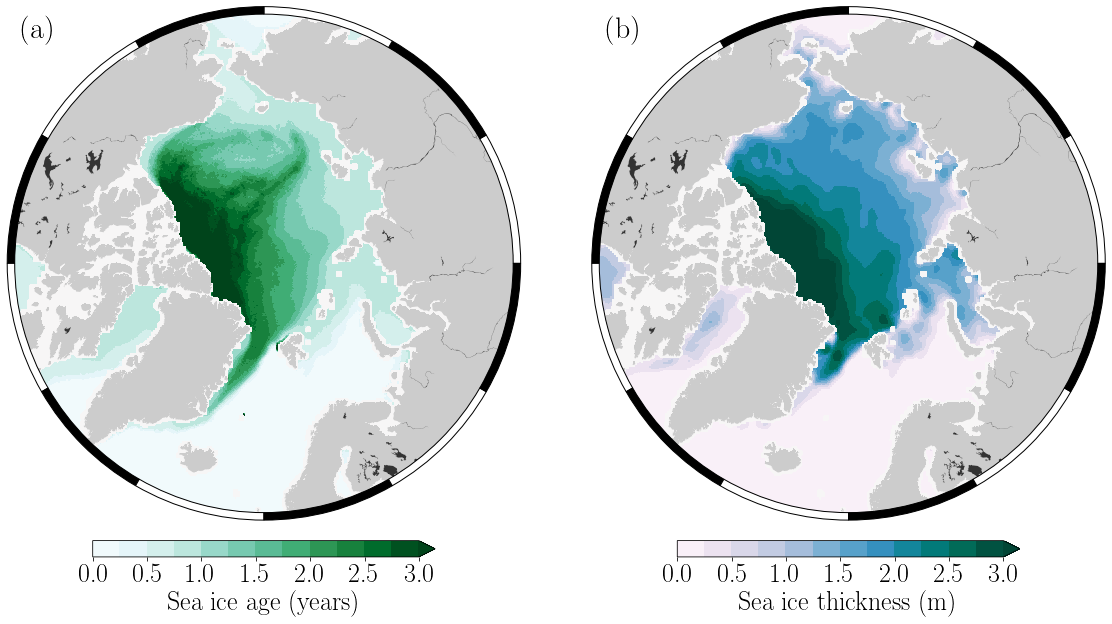

In [14]:
fig,ax = plt.subplots(1,2,figsize=(20,10))

f = open('data/DOT/iceage.pkl','rb')
iceage = pickle.load(f)
f.close()
f = open('data/SIT/AWISMOS_SIT.pkl','rb')
SIT = pickle.load(f)
f.close()
iceage['ice_age'][iceage['ice_age']>10] = np.nan
lons = [iceage['lon'],SIT['lon']] ; lats = [iceage['lat'],SIT['lat']]
SIT['SIT'][SIT['SIT']<-100] = np.nan
SIT['SIT'][np.isnan(SIT['SIT'])] = 0
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l',round=True)
xi,yi = m(SIT['lon'],SIT['lat'])
xr,yr = m(iceage['lon'],iceage['lat'])
sit = griddata((xi.ravel(),yi.ravel()),SIT['SIT'].ravel(),(xr,yr),'nearest')
sit[np.isnan(iceage['ice_age'])] = np.nan

data = [iceage['ice_age'],sit]
cmaps = ['BuGn','PuBuGn']
text = ['(a)','(b)']
caption = ['Sea ice age (years)','Sea ice thickness (m)']
for c in range(2):
    m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l',round=True,ax=ax[c])
    m.fillcontinents(color=(0.8, 0.8, 0.8),lake_color=(0.2, 0.2, 0.2))
    m.drawlsmask(ocean_color=(247/255, 246/255, 246/255))
    ax[c].text(.1e6,6.5e6,text[c],fontsize=30)
    draw_meridians(m,ax[c],hemisphere='north')
    s = m.contourf(xr,yr,data[c],vmin=0,vmax=3,cmap=cmaps[c],levels=np.linspace(0,3,13),rasterized=True,extend='max')
    cbar = fig.colorbar(s,ax=ax[c],orientation='horizontal',pad=0.05,fraction=0.03)
    cbar.set_label(caption[c],fontsize=26)
    cbar.ax.set_xticklabels(['0.0','0.5','1.0','1.5','2.0','2.5','3.0'])
    cbar.ax.tick_params(labelsize=26)
plt.subplots_adjust(wspace=0.1)
plt.show()

# Figure 1.4: The seasonal cycle of sea ice extent, and trends

Daily sea ice extent data can be found at the following location:

https://nsidc.org/data/g02135

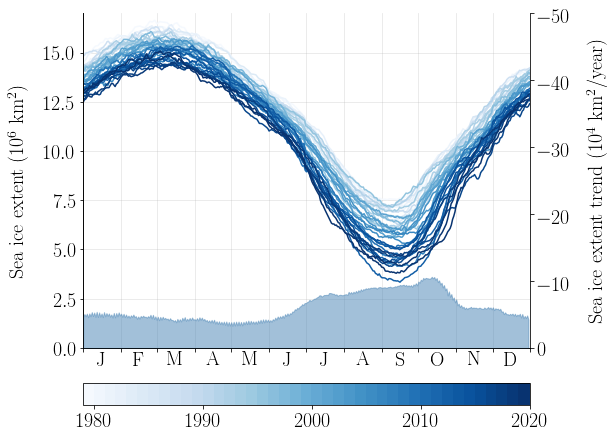

In [21]:
extent = np.genfromtxt('data/SIE/north/N_seaice_extent_daily_v3.0.csv',delimiter=',',skip_header=36,usecols=(0,2,3),skip_footer=177)
mapper = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=1979, vmax=2020), cmap=cmap_discretize(mpl.cm.Blues,2020-1979)) 
array = np.zeros((365,2020-1979+1))*np.nan

fig,ax = plt.subplots(1,figsize=(8,8))
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
for year in range(1979,2020+1):
    if year != 1987:
        ID = np.where(extent[:,0]==year)
        N = np.shape(ID)[1]
        x = np.linspace(0,365,N)
        count = np.floor(np.linspace(extent[:,1][ID][0],365,N)) -1
        for n in range(len(extent[:,2][ID])):
            array[int(count[n]),year-1979] = extent[:,2][ID][n]
        ax.plot(x,extent[:,2][ID],color=mapper.to_rgba(year))
trend = np.zeros(365)
for day in range(365):
    ID = np.where(~np.isnan(array[day,:]))
    sie = array[day,:][ID]
    reg = stats.linregress(np.arange(len(sie)),sie)
    trend[day] = reg[0]

fig.colorbar(mapper,ax=ax,orientation='horizontal',pad=0.08)
ax.grid(True,alpha=.3)
ax.set_xlim(0,365)
ax.set_ylim(0,17)
ax2 = ax.twinx()
ax2.spines['top'].set_color('none')
ax2.fill_between(np.arange(365),trend*100,0,color='steelblue',alpha=.5)
ax2.set_ylim(0,-50)
ax2.set_ylabel('Sea ice extent trend (10$^4$ km$^2$/year)',labelpad=15)
month_starts = [0,31,60,91,121,152,182,213,244,274,305,335,365]
month_mids = []
for i in range(len(month_starts)-1):
    month_mids.append(np.mean([month_starts[i+1],month_starts[i]]))
month_names = ['J','F','M','A','M','J',
               'J','A','S','O','N','D'] 

ax.set_xticks(month_starts,minor=False)
ax.set_xticklabels('',minor=False)
ax.set_xticks(month_mids,minor=True)
ax.set_xticklabels(month_names,minor=True)
ax.tick_params(axis=u'x', which=u'minor',length=0)

ax.set_ylabel('Sea ice extent (10$^6$ km$^2$)',labelpad=15)
plt.show()

# Figure 1.5: Seasonal spatial trends in Arctic sea ice concentration

/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: Mean of empty slice
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/williamgregory/anaconda3/lib/pyth

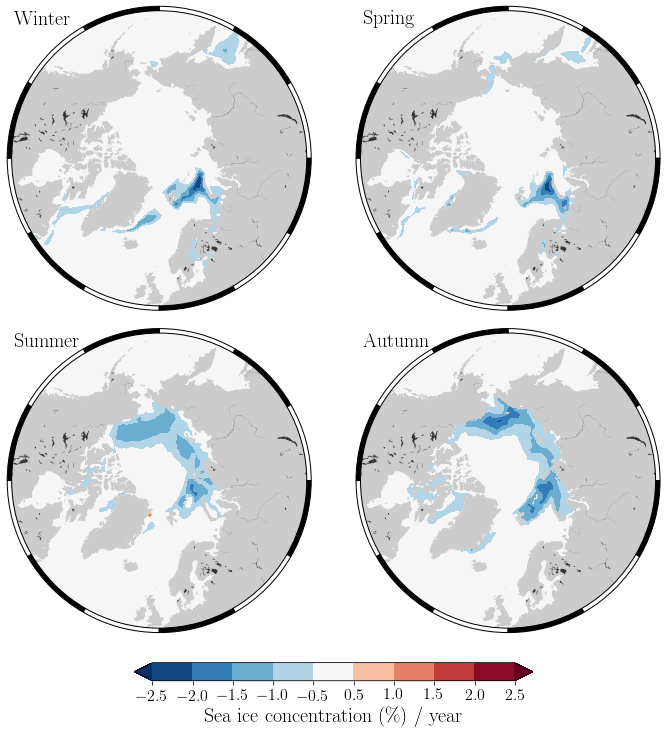

In [22]:
def detrend(dataset,key):
    import itertools
    from scipy import stats
    data = dataset[key+'_data']
    X = data.shape[0] ; Y = data.shape[1]
    nmax = data.shape[2]-2
    trend = np.zeros((X,Y,2)) ; trend[trend==0] = np.nan
    for i,j in itertools.product(range(X),range(Y)):
        if (~np.isnan(data[i,j,range(nmax+1)])).all():
            trendT, interceptT, r_valsT, probT, stderrT = stats.linregress(np.arange(nmax+1),data[i,j,range(nmax+1)])
            trend[i,j,0] = trendT
            trend[i,j,1] = interceptT
    dataset[key+'_trend'] = trend

def readSIC():
    import glob
    import struct
    dimX = 448
    dimY = 304
    months = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
    SIC = {}
    SIC['lat'] = (np.fromfile("data/GRIDS/psn25lats_v3.dat",dtype='<i4').reshape(dimX,dimY))/100000
    SIC['lon'] = (np.fromfile("data/GRIDS/psn25lons_v3.dat",dtype='<i4').reshape(dimX,dimY))/100000
    SIC['psa'] = (np.fromfile("data/GRIDS/psn25area_v3.dat",dtype='<i4').reshape(dimX,dimY))/1000
    for month in range(12):
        monthID = str("%02d"%(month+1))
        days = sorted(glob.glob("data/SIC/daily/2021/nt_2021"+str(monthID)+"*.bin"))
        daily = np.zeros((dimX,dimY,len(days)))*np.nan
        monthly = np.zeros((dimX,dimY,2020-1979+1))*np.nan
        k = -1
        for d in days:
            k = k + 1
            icefile = open(d, "rb")
            contents = icefile.read()
            icefile.close()
            s="%dB" % (int(dimX*dimY),)
            z=struct.unpack_from(s, contents, offset = 300)
            daily[:,:,k] = np.array(z).reshape((dimX,dimY))
        daily = daily/250
        daily[daily>1]=np.nan       
        month_fm_daily = np.nanmean(daily, axis=2)
        k = 0
        for y in range(1979,2020+1):
            icefile = open(glob.glob("data/SIC/monthly/nt_"+str(y)+str(monthID)+"*.bin")[0], "rb")
            contents = icefile.read()
            icefile.close()
            s="%dB" % (int(dimX*dimY),)
            z=struct.unpack_from(s, contents, offset = 300)
            monthly[:,:,k] = np.array(z).reshape((dimX,dimY))
            k = k + 1
        monthly = monthly/250
        monthly[monthly>1]=np.nan
        data = np.concatenate((monthly,month_fm_daily[:,:,np.newaxis]),2)
        SIC[months[month]+'_data'] = data
    DJFM = np.zeros(data.shape)*np.nan
    AM = np.zeros(data.shape)*np.nan
    JJAS = np.zeros(data.shape)*np.nan
    ON = np.zeros(data.shape)*np.nan
    for year in range(1979,2020+1):
        if year == 1979:
            DJFM[:,:,year-1979] = np.nanmean([SIC['jan_data'][:,:,year-1979],SIC['feb_data'][:,:,year-1979],\
                                             SIC['mar_data'][:,:,year-1979]],0)
        else:
            DJFM[:,:,year-1979] = np.nanmean([SIC['dec_data'][:,:,year-1979-1],SIC['jan_data'][:,:,year-1979],\
                                              SIC['feb_data'][:,:,year-1979],SIC['mar_data'][:,:,year-1979]],0)
        AM[:,:,year-1979] = np.nanmean([SIC['apr_data'][:,:,year-1979],SIC['may_data'][:,:,year-1979]],0)
        JJAS[:,:,year-1979] = np.nanmean([SIC['jun_data'][:,:,year-1979-1],SIC['jul_data'][:,:,year-1979],\
                                              SIC['aug_data'][:,:,year-1979],SIC['sep_data'][:,:,year-1979]],0)
        ON[:,:,year-1979] = np.nanmean([SIC['oct_data'][:,:,year-1979],SIC['nov_data'][:,:,year-1979]],0)
    SIC['DJFM_data'] = DJFM ; SIC['AM_data'] = AM ; SIC['JJAS_data'] = JJAS ; SIC['ON_data'] = ON
    detrend(SIC,'DJFM') ; detrend(SIC,'AM') ; detrend(SIC,'JJAS') ; detrend(SIC,'ON')
    return SIC

SIC = readSIC()
fig,ax = plt.subplots(2,2,figsize=(10,10))
months1 = ['DJFM','AM','JJAS','ON']
months2 = ['Winter','Spring','Summer','Autumn']
levels = [-2.5,-2,-1.5,-1,-.5,.5,1,1.5,2,2.5]
k = 0
for ax1 in range(2):
    for ax2 in range(2):
        m = Basemap(projection='npstere',boundinglat=50,lon_0=0,resolution='l',round=True,ax=ax[ax1,ax2])
        x,y = m(SIC['lon'],SIC['lat'])
        m.fillcontinents(color=(0.8, 0.8, 0.8),lake_color=(0.2, 0.2, 0.2))
        m.drawlsmask(ocean_color=(247/255, 246/255, 246/255))
        s = m.contourf(x,y,SIC[months1[k]+'_trend'][:,:,0]*100,vmin=-2.5,vmax=2.5,cmap='RdBu_r',extend='both',rasterized=True,levels=levels)
        draw_meridians(m,ax[ax1,ax2],hemisphere='north')
        ax[ax1,ax2].text(.01,0.95,months2[k],transform=ax[ax1,ax2].transAxes)
        k += 1
plt.tight_layout()
cbar = fig.colorbar(s,ax=ax.ravel(),pad=0.05,fraction=0.027,orientation='horizontal',extend='both')
cbar.set_label('Sea ice concentration ($\%$) / year')
cbar.ax.tick_params(labelsize=16)
plt.show()


# Figure 1.6: Z-score of monthly mean pan-Arctic sea ice extent

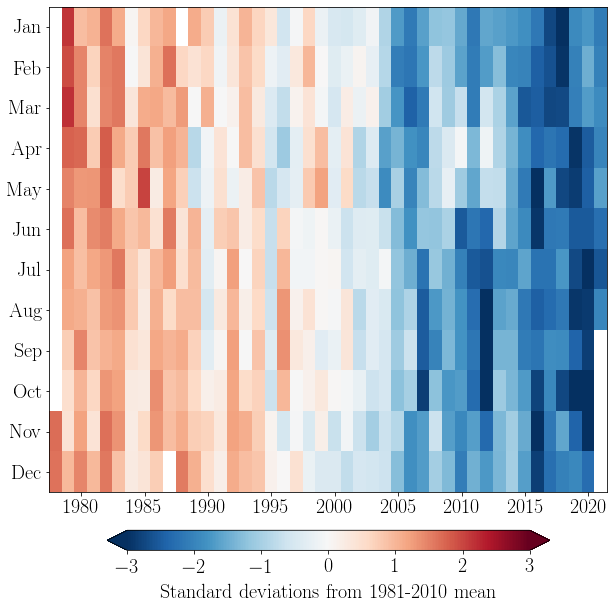

In [23]:

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
data = np.zeros((12,2021-1978+1))*np.nan
from scipy import stats
for k in range(1,12+1):
    si = np.genfromtxt('data/SIE/N_'+str('%02d'%k)+'_extent_v3.0.csv',delimiter=',').T[4:][:,1:]
    isnan = np.where(si[0,:]<0)
    if np.shape(isnan)[1]>0:
        si[0,isnan[0][0]] = (si[0,isnan[0][0]+1]+si[0,isnan[0][0]-1])/2
    if k >= 11:
        start = 1978
    else:
        start = 1979
    if k < 9:
        end = 2021
    else:
        end = 2020
    refmean = np.nanmean(si[0,1981-start:2010-start+1])
    refstd = np.nanstd(si[0,1981-start:2010-start+1])
    for year in range(start,end+1):
        data[k-1,year-1978] = (si[0,year-start]-refmean)/refstd

data[0,10] = np.nan
data[11,9] = np.nan

fig,ax = plt.subplots(1,figsize=(10,10))
s = ax.imshow(data,aspect='auto',cmap='RdBu_r',vmin=-3,vmax=3,interpolation='none',rasterized=True)
ax.set_yticks(np.arange(12))
ax.set_yticklabels(months)
ax.set_ylim(11.5,-.5)
ax.set_xticks(np.arange(2,2021-1978+1,5))
ax.set_xticklabels(np.arange(1980,2021+1,5))
cbar = fig.colorbar(s,ax=ax,orientation='horizontal',pad=0.07,fraction=0.037,extend='both')
cbar.set_label('Standard deviations from 1981-2010 mean',labelpad=10)
plt.show()

    


# Figure 1.7: Trends in sea ice melt onset, freezeup and the length of melt 

Melt onset, freezeup and length of melt season data can be found at NSIDC:

https://nsidc.org/data/NSIDC-0747/versions/1

/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in less
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


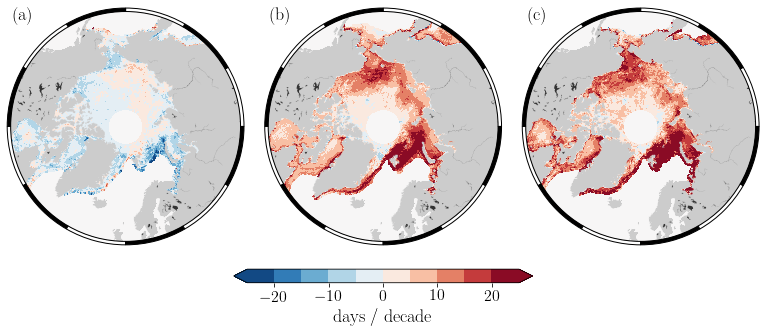

In [24]:
def detrend(data):
    import itertools
    from scipy import stats
    X = data.shape[0] ; Y = data.shape[1]
    trend = np.zeros((X,Y))*np.nan
    inputs = np.arange(1979,2017+1)
    end = 2017-1979+1
    for i,j in itertools.product(range(X),range(Y)):
        if (np.isnan(data[i,j,:end])).all():    
            pass
        else:
            IDs = np.where(~np.isnan(data[i,j,:end]))
            if np.shape(IDs)[1]>20:#(inputs[IDs][0] == 1979) & (inputs[IDs][-1] == 2017):
                t2 = stats.linregress(inputs[IDs],data[i,j,:end][IDs])
                trend[i,j] = t2[0]
    return trend

def readMO(key):
    f = Dataset('data/arctic_seaice_climate_indicators_nh_v01r01_1979-2017.nc')
    if key == 'IML':
        data1 = np.array(f['EFO']).astype('float32').transpose(1,2,0)
        data2 = np.array(f['CMO']).astype('float32').transpose(1,2,0)
        data1[data1<=0] = np.nan
        data2[data2<=0] = np.nan
        data = data1 - data2
    elif key == 'OML':
        data1 = np.array(f['CFO']).astype('float32').transpose(1,2,0)
        data2 = np.array(f['EMO']).astype('float32').transpose(1,2,0)
        data1[data1<=0] = np.nan
        data2[data2<=0] = np.nan
        data = data1 - data2
    elif key == 'CML':
        data1 = np.array(f['CFO']).astype('float32').transpose(1,2,0)
        data2 = np.array(f['CMO']).astype('float32').transpose(1,2,0)
        data1[data1<=0] = np.nan
        data2[data2<=0] = np.nan
        data = data1 - data2
    elif key == 'EML':
        data1 = np.array(f['EFO']).astype('float32').transpose(1,2,0)
        data2 = np.array(f['EMO']).astype('float32').transpose(1,2,0)
        data1[data1<=0] = np.nan
        data2[data2<=0] = np.nan
        data = data1 - data2
    elif key == 'MO':
        data1 = np.array(f['EMO']).astype('float32').transpose(1,2,0)
        data2 = np.array(f['CMO']).astype('float32').transpose(1,2,0)
        data1[data1<=0] = np.nan
        data2[data2<=0] = np.nan
        data = np.nanmean([data1,data2],0)
    elif key == 'FO':
        data1 = np.array(f['EFO']).astype('float32').transpose(1,2,0)
        data2 = np.array(f['CFO']).astype('float32').transpose(1,2,0)
        data1[data1<=0] = np.nan
        data2[data2<=0] = np.nan
        data = np.nanmean([data1,data2],0)
    else:
        data = np.array(f[key]).astype('float32').transpose(1,2,0)
        data[data<=0] = np.nan
    return detrend(data)

CMO_trend = readMO('CMO')
EFO_trend = readMO('EFO')
IML_trend = readMO('IML')
f = Dataset('data/arctic_seaice_climate_indicators_nh_v01r01_1979-2017.nc')
lon = np.array(f['longitude'])
lat = np.array(f['latitude'])
CMO_trend[lat>=84.5] = np.nan
EFO_trend[lat>=84.5] = np.nan
IML_trend[lat>=84.5] = np.nan
mask = np.load('data/NSIDC_regions.npy')
mask[mask>15] = np.nan
mask[mask<2] = np.nan

regions = ['Sea of Okhotsk','Bering Sea','Hudson Bay','Atlantic','Baffin Bay','GIN','Barents','Kara',\
          'Laptev','ESS','Chukchi','Beaufort','CAA','CA']
ids = np.arange(2,15+1)

levels = np.arange(-25,30,5)
text = ['(a)','(b)','(c)']
plots = [CMO_trend*10,EFO_trend*10,IML_trend*10]

fig,ax = plt.subplots(1,3,figsize=(15,5))
for c in range(3):
    ax[c].text(.1e6,7.7e6,text[c],fontsize=18)
    m = Basemap(projection='npstere',boundinglat=55,lon_0=0,resolution='l',round=True,ax=ax[c])
    x,y = m(lon,lat)
    m.fillcontinents(color=(0.8, 0.8, 0.8),lake_color=(0.2, 0.2, 0.2))
    m.drawlsmask(ocean_color=(247/255, 246/255, 246/255))
    s = m.pcolormesh(x,y,plots[c],cmap=cmap_discretize('RdBu_r',10),vmin=-25,vmax=25,rasterized=True)
    draw_meridians(m,ax[c],hemisphere='north')
plt.subplots_adjust(wspace=-0.2)
cbar = fig.colorbar(s,ax=ax.ravel(),pad=0.1,fraction=0.05,orientation='horizontal',extend='both')
cbar.set_label('days / decade',fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.show()


# Figure 1.8: Trends in winter sea ice age

/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: The following kwargs were not used by contour: 'rasterized'


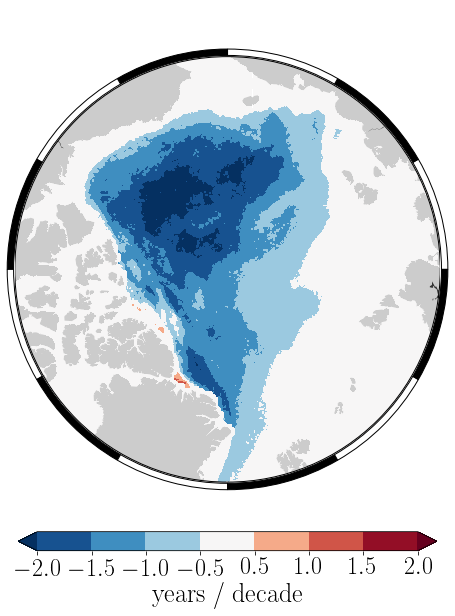

/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/williamgregory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


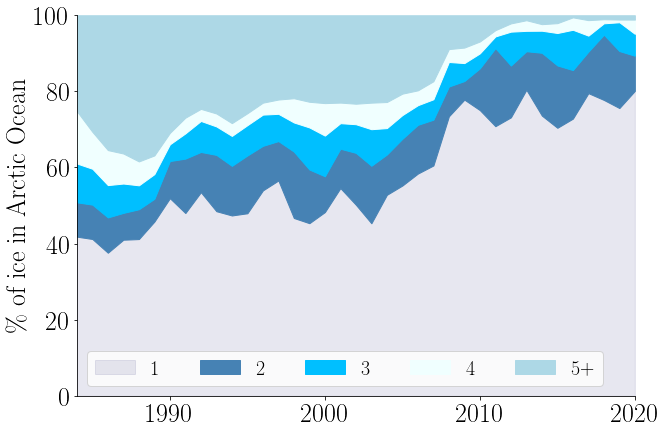

In [26]:
f = open('data/DOT/DJFM_iceage.pkl','rb')
iceage = pickle.load(f)
f.close()
iceage['ice_age'][iceage['ice_age']>=20] = np.nan

def dt(data):
    dX,dY,dT = data.shape
    trend = np.zeros((dX,dY))*np.nan
    for ix in range(dX):
        for jx in range(dY):
            if (~np.isnan(data[ix,jx,:])).all():
                reg = stats.linregress(np.arange(1984,2020+1),data[ix,jx,:])
                trend[ix,jx] = reg[0]
    return trend

trend = dt(iceage['ice_age'])
fig,ax = plt.subplots(1,figsize=(10,10))
m = Basemap(llcrnrlon=-50, llcrnrlat=65, urcrnrlon=150, urcrnrlat=60,
                resolution='l',projection='stere',lat_0=90,lon_0=0,ax=ax,round=True)
x,y = m(iceage['lon'],iceage['lat'])
m.fillcontinents(color=(0.8, 0.8, 0.8),lake_color=(0.2, 0.2, 0.2))
m.drawlsmask(ocean_color=(247/255, 246/255, 246/255))
draw_meridians(m,ax,hemisphere='north')
levels = [-2,-1.5,-1,-.5,.5,1,1.5,2]
s = m.contourf(x,y,trend*10,cmap='RdBu_r',vmin=-2,vmax=2,levels=levels,rasterized=True,extend='both')
cbar = fig.colorbar(s,ax=ax,pad=0.0,fraction=0.035,orientation='horizontal')
cbar.set_label('years / decade',fontsize=26)
cbar.ax.tick_params(labelsize=24)
plt.show()

regions = Dataset('data/NSIDC_Regions_Masks-2.nc')
regions_lon = np.array(regions['lon']) ; regions_lat = np.array(regions['lat'])
m = Basemap(llcrnrlon=-50, llcrnrlat=65, urcrnrlon=150, urcrnrlat=60,
                resolution='l',projection='stere',lat_0=90,lon_0=0,ax=ax,round=True)
regions_x,regions_y = m(regions_lon,regions_lat)
regions = griddata((regions_x.ravel(),regions_y.ravel()),np.array(regions['mask']).ravel(),(x,y),'nearest').astype('float32')
regions[regions<8.] = np.nan
regions[regions==14] = np.nan
regions[regions>16] = np.nan
iceage['ice_age'][iceage['ice_age']==0] = np.nan
y1 = []
y2 = []
y3 = []
y4 = []
for year in range(1984,2020+1):
    g0 = iceage['ice_age'][:,:,year-1984]>0
    total = np.shape(np.where((~np.isnan(regions)) & (g0)))[1]
    y1.append(100*np.shape(np.where((~np.isnan(regions)) & (iceage['ice_age'][:,:,year-1984]<=2) & (g0)))[1]/total)
    y2.append(100*np.shape(np.where((~np.isnan(regions)) & (iceage['ice_age'][:,:,year-1984]<=3) & (g0)))[1]/total)
    y3.append(100*np.shape(np.where((~np.isnan(regions)) & (iceage['ice_age'][:,:,year-1984]<=4) & (g0)))[1]/total)
    y4.append(100*np.shape(np.where((~np.isnan(regions)) & (iceage['ice_age'][:,:,year-1984]<=5) & (g0)))[1]/total)

fig,ax = plt.subplots(1,figsize=(10,7))
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.fill_between(np.arange(1984,2020+1),0,y1,color='midnightblue',label='1',alpha=.1)
ax.fill_between(np.arange(1984,2020+1),y1,y2,color='steelblue',label='2')
ax.fill_between(np.arange(1984,2020+1),y2,y3,color='deepskyblue',label='3')
ax.fill_between(np.arange(1984,2020+1),y3,y4,color='azure',label='4')
ax.fill_between(np.arange(1984,2020+1),y4,100,color='lightblue',label='5+')
ax.set_xlim(1984,2020)
ax.legend(loc='lower left',frameon=True,ncol=5)
ax.set_ylim(0,100)
ax.set_ylabel('\% of ice in Arctic Ocean',fontsize=26)
ax.tick_params(axis='both', which='major', labelsize=26)
plt.show()

# Figure 1.9: The sign of anthropogenic warming in models and observations

CMIP6 data archives can be accessed through the following web portal:

https://esgf-node.llnl.gov/projects/cmip6/

or by using the Python download script https://github.com/tloureiro/cmip6_downloader created by Thiago Loureiro

HadCRUT5 data can be accessed from the MetOffice at 

https://www.metoffice.gov.uk/hadobs/hadcrut5/

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


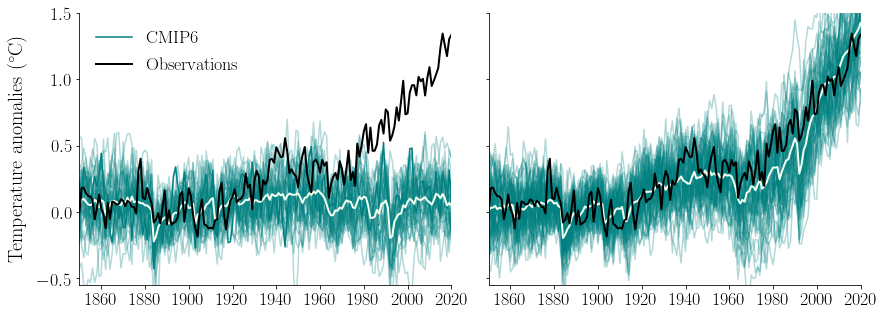

In [27]:
ta = np.loadtxt('data/crut5.txt',delimiter='\t',dtype=str)
ta_obs = []

dates = np.arange(1850.0,2021.0)

for k in range(len(ta)-2):
    if (k % 2) == 0:
        ta_obs.append(float(ta[k].split(' ')[-1]))
        
ta_obs = ta_obs - np.mean(ta_obs[1880-1850:1919-1850+1])
        
f = open('data/CMIP6/CMIP6_all_models_hist-nat_tasmon_data.pkl','rb')
tas = pickle.load(f)
f.close()
f = open('data/CMIP6/CMIP6_all_models_hist-nat_tasmon_dates.pkl','rb')
tas_dates = pickle.load(f)
f.close()
f = open('data/CMIP6/CMIP6_all_models_tasmon_data_ssp585.pkl','rb')
tas_ssp585 = pickle.load(f)
f.close()

fig,ax = plt.subplots(1,2,sharey=True,figsize=(14,5))
mean = []
unavail = []
k = 0
for key in tas:
    if key.split('_')[0] not in unavail:
        unavail.append(key.split('_')[0])
    x = np.arange(tas_dates[key][0],tas_dates[key][1]+1)
    if k == 30:
        ax[0].plot(x,tas[key],color='teal',alpha=1,label='CMIP6')
    else:
        ax[0].plot(x,tas[key],color='teal',alpha=.3)
    if tas_dates[key][1] < 2020:
        data = np.concatenate((tas[key],np.ones(2020-tas_dates[key][1])*np.nan))
    else:
        data = tas[key]
    mean.append(data)
    k += 1
ax[0].plot(np.arange(1850,2020+1),np.nanmean(mean,0),color='honeydew',lw=2)
mean = []
unavail = []
for key in tas_ssp585:
    if key.split('_')[0] not in unavail:
        unavail.append(key.split('_')[0])
    if key.split('_')[0] != 'CanESM5':
        ax[1].plot(np.arange(1850,2020+1),tas_ssp585[key],color='teal',alpha=.3)
        mean.append(tas_ssp585[key])
ax[1].plot(np.arange(1850,2020+1),np.nanmean(mean,0),color='honeydew',lw=2)
for c in range(2):
    ax[c].spines['top'].set_color('none')
    ax[c].spines['right'].set_color('none')
    ax[c].plot(np.arange(1850,2020+1),ta_obs,color='k',lw=2,label='Observations')
    ax[c].set_xlim(1850,2020)
    ax[c].xaxis.set_ticks(np.arange(1860,2040,20))
    ax[c].set_ylim(-0.55,1.5)
    ax[c].tick_params(axis='both', which='major', labelsize=18)
ax[0].set_ylabel('Temperature anomalies ($^\circ$C)',fontsize=20,labelpad=10)
ax[0].legend(loc='upper left',frameon=False,fontsize=18)
plt.subplots_adjust(wspace=0.1)
plt.show()

# Figure 1.10: Sea ice area evolution into the 21st century

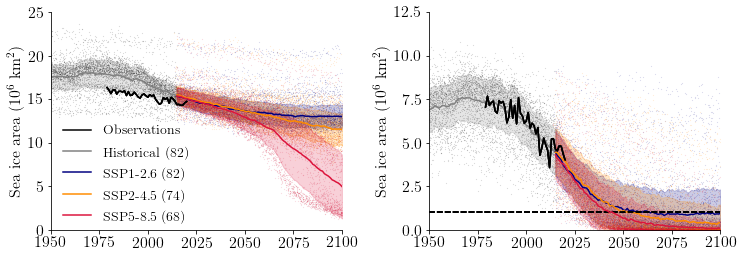

In [230]:
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

f = open('data/CMIP6/CMIP6_all_models_mon_data_ssp126_1950-2100.pkl','rb')
s126 = pickle.load(f)
f.close()
f = open('data/CMIP6/CMIP6_all_models_mon_data_ssp245_1950-2100.pkl','rb')
s245 = pickle.load(f)
f.close()
f = open('data/CMIP6/CMIP6_all_models_mon_data_ssp585_1950-2100.pkl','rb')
s585 = pickle.load(f)
f.close()
subset = ['ACCESS-CM2','ACCESS-ESM1-5','CESM2-WACCM','CNRM-ESM2-1','CanESM5','EC-Earth3','EC-Earth3-Veg',\
         'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MIROC6','MRI-ESM2-0','NorESM2-LM']
sim = np.genfromtxt('/Users/williamgregory/Documents/Datasets/SIE/north/N_03_extent_v3.0.csv',delimiter=',').T[4][1:-1]
sis = np.genfromtxt('/Users/williamgregory/Documents/Datasets/SIE/north/N_09_extent_v3.0.csv',delimiter=',').T[4][1:]
obs = [sim,sis]
cmip = [s126,s245,s585]
ssps = ['SSP1-2.6 (82)','SSP2-4.5 (74)','SSP5-8.5 (68)']
labels = ['(a)','(b)']
color = ['navy','darkorange','crimson']
ylim = [[0,25],[0,12.5]]
s = 0.01
fig,ax = plt.subplots(1,2,figsize=(12,4))
k = 0
for ssp in cmip:
    tsm = [] ; tss = []
    for c in range(2):
        ax[c].spines['top'].set_color('none')
        ax[c].spines['right'].set_color('none')
        if k == 0:
            ax[c].plot(np.arange(1979,2020+1),obs[c],color='k',label='Observations')
        else:
            ax[c].plot(np.arange(1979,2020+1),obs[c],color='k')
        ax[c].set_ylim(ylim[c])
        ax[c].set_xlim(1950,2100)
        ax[c].set_ylabel('Sea ice area (10$^6$ km$^2$)',fontsize=16)
        ax[c].tick_params(axis='both', which='major', labelsize=16)
        ax[1].axhline(y=1,color='k',ls='--')
    p = 0
    unavail = []
    for key in ssp:
        if key.split('_')[0] not in unavail:
            unavail.append(key.split('_')[0])
        for c in range(2):
            if len(ssp[key][c,:]) == 151:
                if k == 0:
                    ax[c].scatter(rand_jitter(np.arange(1950,2015+1)),ssp[key][c,:2016-1950]/1e12,color='k',rasterized=True,s=s,alpha=.5)
                ax[c].scatter(rand_jitter(np.arange(2015,2100+1)),ssp[key][c,2015-1950:]/1e12,color=color[k],rasterized=True,s=s,alpha=.5)
                tsm.append(ssp[key][0,:]/1e12)
                tss.append(ssp[key][1,:]/1e12)
            else:
                if k == 0:
                    ax[c].scatter(rand_jitter(np.arange(1950,2015+1)),ssp[key][c,:2016-1950]/1e12,color='k',rasterized=True,s=s,alpha=.5)
                ax[c].scatter(rand_jitter(np.arange(2015,2099+1)),ssp[key][c,2015-1950:]/1e12,color=color[k],rasterized=True,s=s,alpha=.5)
        p += 1
    all_ts = [np.array(tsm),np.array(tss)]
    for c in range(2):
        if k == 0:
            ax[c].plot(np.arange(1950,2015+1),np.mean(all_ts[c][:,:2016-1950],0),color='gray',label='Historical (82)')
            ax[c].fill_between(np.arange(1950,2015+1),np.mean(all_ts[c][:,:2016-1950],0)+np.std(all_ts[c][:,:2016-1950],0),\
                              np.mean(all_ts[c][:,:2016-1950],0)-np.std(all_ts[c][:,:2016-1950],0),color='gray',alpha=.2)
        ax[c].plot(np.arange(2015,2100+1),np.mean(all_ts[c][:,2015-1950:],0),color=color[k],label=ssps[k])
        ax[c].fill_between(np.arange(2015,2100+1),np.mean(all_ts[c][:,2015-1950:],0)+np.std(all_ts[c][:,2015-1950:],0),\
                          np.mean(all_ts[c][:,2015-1950:],0)-np.std(all_ts[c][:,2015-1950:],0),color=color[k],alpha=.2)
        
    k += 1
ax[0].legend(frameon=False,fontsize=14,loc='lower left',bbox_to_anchor=(0,-.03,.77,.77))
plt.subplots_adjust(wspace=.3)
plt.show()

# Figure 1.11: Sea ice persistence and re-emergence

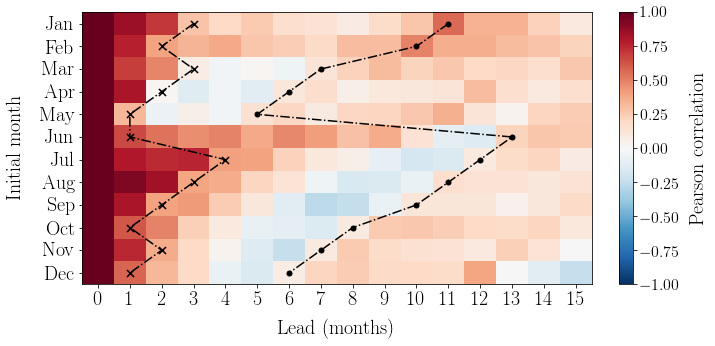

In [29]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ID = np.triu_indices(n=12,m=16,k=1)
ID = (11-np.array(ID[0]),np.array(ID[1]))
IDs = [[ID[0][i],ID[1][i]] for i in range(np.shape(ID)[1])]
aoe = 0 #0 for extent, 1 for area
R = np.zeros((12,16))*np.nan
for target in range(12):
    si1 = np.genfromtxt('data/SIE/N_'+str('%02d'%(target+1))+'_extent_v3.0.csv',delimiter=',').T[4:][:,1:]
    isnan = np.where(si1[aoe,:]<0)
    if np.shape(isnan)[1]>0:
        si1[aoe,isnan[0][0]] = (si1[aoe,isnan[0][0]+1]+si1[aoe,isnan[0][0]-1])/2
    if target < 8:
        si1 = si1[aoe,:-1]
    elif target >= 10:
        si1 = si1[aoe,1:]
    else:
        si1 = si1[aoe,:]
    trend = stats.linregress(np.arange(len(si1)),si1)
    si1 = si1 - (np.arange(len(si1))*trend[0] + trend[1])
    leads = np.concatenate((np.arange(target+1,13,1),np.arange(0,target+4)+1))
    leads[leads==13] = 1 ; leads[leads==14] = 2 ; leads[leads==15] = 3
    for lead in range(len(leads)):
        si2 = np.genfromtxt('data/SIE/N_'+str('%02d'%leads[lead])+'_extent_v3.0.csv',delimiter=',').T[4:][:,1:]
        isnan = np.where(si2[aoe,:]<0)
        if np.shape(isnan)[1]>0:
            si2[aoe,isnan[0][0]] = (si2[aoe,isnan[0][0]+1]+si2[aoe,isnan[0][0]-1])/2
        if leads[lead] < 9:
            si2 = si2[aoe,:-1]
        elif leads[lead] >= 11:
            si2 = si2[aoe,1:]
        else:
            si2 = si2[aoe,:]
        trend = stats.linregress(np.arange(len(si2)),si2)
        si2 = si2 - (np.arange(len(si2))*trend[0] + trend[1])
        corr,P = stats.pearsonr(si1,si2)
        if [target,lead] in IDs:
            if ((target == 9) & (lead == 15)) or ((target == 10) & (lead >= 14)) or ((target == 11) & (lead >= 13)):
                corr,P = stats.pearsonr(si1[:-2],si2[2:])
            else:
                corr,P = stats.pearsonr(si1[:-1],si2[1:])
            if P/2 < 1:
                R[target,lead] = corr
        else:
            corr,P = stats.pearsonr(si1,si2)
            if P/2 < 1:
                R[target,lead] = corr

R_diff = np.diff(R,axis=1)
min_diff = [np.where(R_diff[k,:]==np.min(R_diff[k,:]))[0][0]+1 for k in range(12)]
max_diff = [np.where(R_diff[k,:]==np.max(R_diff[k,:]))[0][0]+1 for k in range(12)]
fig,ax = plt.subplots(1,figsize=(10,5))
s = ax.imshow(R,aspect='auto',cmap='RdBu_r',vmin=-1,vmax=1,interpolation='none',rasterized=True)
ax.scatter(max_diff,np.arange(12),color='k',s=100,marker='.')
ax.plot(max_diff,np.arange(12),color='k',ls='-.')
ax.scatter(min_diff,np.arange(12),color='k',s=50,marker='x')
ax.plot(min_diff,np.arange(12),color='k',ls='-.')
ax.set_yticks(np.arange(12))
ax.set_yticklabels(months)
ax.set_xlabel('Lead (months)',labelpad=10)
ax.set_xticks(np.arange(16))
ax.set_xticklabels(np.arange(16))
ax.set_ylim(11.5,-.5)
ax.set_xlim(-.5,15.5)
ax.set_ylabel('Initial month',labelpad=15)
cbar = fig.colorbar(s,ax=ax,pad=0.05,fraction=0.037)
cbar.set_label('Pearson correlation',labelpad=10)
cbar.ax.tick_params(labelsize=16)
plt.show()